In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Union, Tuple, List

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")

import optuna
from optuna.visualization import (
    plot_edf
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances

    , plot_slice
)

# local modules
import sys
sys.path.append("../src")
from preproc import preprocess_data

PyTorch version: 2.4.1
PyTorch Lightning version: 2.4.0


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lightning.pytorch import seed_everything
seed_everything(2112, workers=True);

Seed set to 2112


***
### load and preprocess data

In [3]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [4]:
# Call the function
df_train, df_test, numerical_cols, categorical_cols = preprocess_data(
    df_train,
    df_test,
    scale_utility=True
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

Numerical Columns: 588
Categorical Columns: 10


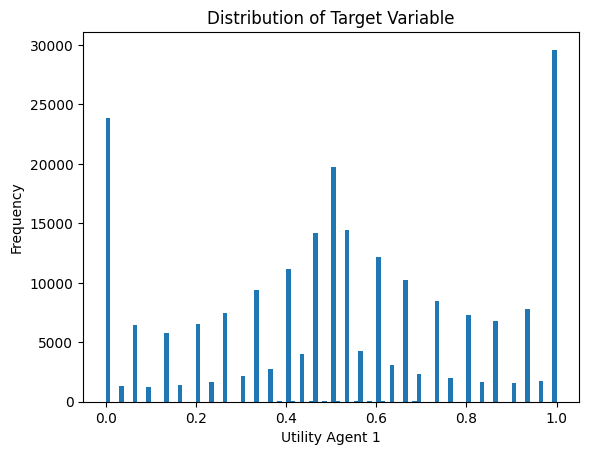

In [5]:
plt.hist(df_train['utility_agent1_scaled'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
df_train[numerical_cols] = df_train[numerical_cols].astype(np.float32)
df_train[categorical_cols] = df_train[categorical_cols].astype(np.int32)

cat_input_dims = df_train[categorical_cols].nunique(axis=0).values.tolist()
print(cat_input_dims)

[72, 72, 4, 3, 3, 2, 4, 3, 3, 2]


In [7]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns of df_train
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])

# Print a message to confirm the scaling
print("Numerical columns have been scaled using StandardScaler.")


Numerical columns have been scaled using StandardScaler.


***
### train model


In [8]:
class MLP(pl.LightningModule):

    def __init__(self, 
            num_input_dim: int,
            cat_input_dims: list[int],
            output_dim: int,
            layers: str,
            dropout: float,
            learning_rate: float = 1e-3,
            weight_decay: float = 1e-5,
            initialization: str = 'kaiming_uniform',
            embedding_dim: Optional[List[int]] = None,
            pct_start: float = 0.2,

        ):
        super().__init__()
        self.save_hyperparameters()
        self.dropout = dropout
        self.pct_start = pct_start

        # Initialize embedding dimensions if not provided
        if embedding_dim is None:
            # Rule of thumb: min(50, num_unique // 2 + 1) for each categorical feature
            embedding_dim = [min(50, int(1 + np.ceil(np.sqrt(dim)))) for dim in cat_input_dims]

        elif len(embedding_dim) != len(cat_input_dims):
            raise ValueError("Length of embedding_dim must match number of categorical features.")

        self.embedding_dim = embedding_dim

        # Create embedding layers
        self.create_embeddings(cat_input_dims, embedding_dim)

        # Create backbone layers
        self.create_backbone(num_input_dim, layers)

        # Create head layers
        self.create_head(output_dim)

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.initialization = initialization

        self._init_weights()

        # Initialize lists to store validation outputs
        self.validation_targets = []
        self.validation_predictions = []

    def create_embeddings(self, cat_input_dims: list[int], embedding_dim: list[int]):
        self.embeddings = nn.ModuleList(
            [nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_input_dims, embedding_dim)]
        )

    def create_backbone(self, num_input_dim: int, layers: str):
        # Calculate total input dimension after embeddings
        total_embedding_dim = sum(self.embedding_dim)
        total_input_dim = num_input_dim + total_embedding_dim

        # Parse layers string
        layer_sizes = [int(size) for size in layers.split('-')]

        # Create backbone network layers
        backbone_layers = []
        prev_size = total_input_dim
        for size in layer_sizes:
            backbone_layers.extend([
                nn.BatchNorm1d(prev_size),
                nn.Linear(prev_size, size),
                nn.ReLU(),
                nn.Dropout(self.hparams.dropout),
            ])
            prev_size = size
        self.backbone = nn.Sequential(*backbone_layers)
        self.backbone_output_size = prev_size

    def create_head(self, output_dim: int):
        # Output layer
        self.head = nn.Sequential(
            nn.BatchNorm1d(self.backbone_output_size),
            nn.Linear(self.backbone_output_size, output_dim)
        )

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if self.initialization == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                elif self.initialization == 'kaiming_normal':
                    nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                elif self.initialization == 'xavier_uniform':
                    nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                elif self.initialization == 'xavier_normal':
                    nn.init.xavier_normal_(module.weight, gain=nn.init.calculate_gain('relu'))
                else:
                    raise ValueError(f"Unsupported initialization method: {self.initialization}")
                
                # Initialize bias to small values
                if module.bias is not None:
                    nn.init.uniform_(module.bias, -0.1, 0.1)

    def forward(self, x_num, x_cat):
        # Process categorical variables
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)
        
        # Concatenate numerical and embedded categorical features
        x = torch.cat([x_num, embedded], dim=1)
        
        # Pass through backbone
        x = self.backbone(x)
        
        # Pass through head
        x = self.head(x)
        x = nn.functional.hardtanh(x)

        return x.squeeze(-1)

    def training_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('valid_loss', loss, prog_bar=True)
        # Store targets and predictions for later use
        self.validation_targets.append(y)
        self.validation_predictions.append(y_hat)
        return loss
    
    def predict_step(self, batch, batch_idx):
        if len(batch) == 2:
            x_num, x_cat = batch
        elif len(batch) == 3:
            x_num, x_cat, _ = batch
        y_hat = self(x_num, x_cat)
        return y_hat

    def on_validation_epoch_end(self):
        # Concatenate all targets and predictions
        y = torch.cat(self.validation_targets)
        y_hat = torch.cat(self.validation_predictions)
        rmse = torch.sqrt(F.mse_loss(y_hat, y))
        self.log('val_rmse', rmse, prog_bar=True)
        # Clear the lists for next epoch
        self.validation_targets.clear()
        self.validation_predictions.clear()
                
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay,
        )
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=self.pct_start,
            anneal_strategy='cos',
            cycle_momentum=True,
            base_momentum=0.85,
            max_momentum=0.95,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

In [9]:
# Define the number of folds for cross-validation
num_folds = 5

# Define the column for stratified or group k-fold
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = list(gkf.split(df_train, groups=df_train[groups_col]))

early_stop_callback = EarlyStopping(
    monitor='val_rmse',
    patience=10,
    mode='min',
    verbose=False
)

def train_and_score(
        batch_size,
        dropout,
        input_layer_size,
        n_layers,
        learning_rate,
        weight_decay,
        initialization,
        pct_start,
    ):
    oof_scores = []

    # Perform cross-validation
    for _, (train_index, val_index) in enumerate(split_list, 1):
        
        # Split the data
        train, valid = df_train.iloc[train_index], df_train.iloc[val_index]

        train_dataset = TensorDataset(
            torch.tensor(train[numerical_cols].values, dtype=torch.float32),
            torch.tensor(train[categorical_cols].values, dtype=torch.int32),
            torch.tensor(train['utility_agent1'].values, dtype=torch.float32)
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=8,
            persistent_workers=True
        )

        valid_dataset = TensorDataset(
            torch.tensor(valid[numerical_cols].values, dtype=torch.float32),
            torch.tensor(valid[categorical_cols].values, dtype=torch.int32),
            torch.tensor(valid['utility_agent1'].values, dtype=torch.float32)
        )
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=8,
            persistent_workers=True
        )

        # Construct the layers string based on input_layer_size and n_layers
        layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

        model = MLP(
            num_input_dim=len(numerical_cols),
            cat_input_dims=cat_input_dims,
            output_dim=1,
            layers=layers,
            dropout=dropout,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            initialization=initialization,
            pct_start=pct_start,
        )
        trainer = pl.Trainer(
            min_epochs=20,
            max_epochs=100, 
            deterministic=True,
            accelerator="mps",
            enable_progress_bar=False,
            enable_model_summary=False,
            callbacks=[
                early_stop_callback, 
                ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
            ],
        );
        trainer.fit(
            model, 
            train_loader,
            valid_loader,
        );

        # Load the best model
        best_model_path = trainer.checkpoint_callback.best_model_path
        model = MLP.load_from_checkpoint(best_model_path)

        # Predict on validation set using trainer.predict with the prediction DataLoader
        predictions = trainer.predict(model, dataloaders=valid_loader)
        y_pred = torch.cat(predictions).squeeze().cpu().numpy()
         
        # Compute RMSE on scaled values
        y_valid = valid['utility_agent1'].values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        oof_scores.append(rmse)

    return np.mean(oof_scores)


In [10]:
def objective(trial):
    # Suggest hyperparameters to tune
    batch_size = trial.suggest_int('batch_size', 128, 1024, step=64)
    dropout = trial.suggest_float('dropout', 0.0, 0.3, step=0.05)
    input_layer_size = trial.suggest_int('input_layer_size', 256, 1024, step=64)
    n_layers = trial.suggest_int('n_layers', 2, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    initialization = trial.suggest_categorical('initialization', ['kaiming_uniform', 'xavier_uniform'])
    pct_start = trial.suggest_float('pct_start', 0.05, 0.4, step=0.05)

    # Train and evaluate the model with the suggested hyperparameters
    oof_score = train_and_score(
        batch_size=batch_size,
        dropout=dropout,
        input_layer_size=input_layer_size,
        n_layers=n_layers,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        initialization=initialization,
        pct_start=pct_start,
    )

    return oof_score


In [11]:
do_optimize = True
timeout = 3600 * 14

study = optuna.create_study(
    study_name="mlp",
    direction='minimize',
    storage='sqlite:///mlp.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=timeout,
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2024-10-02 17:12:50,841] Using an existing study with name 'mlp' instead of creating a new one.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Loading `train_dataloader` to estimate number of stepping batches.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_initialization,params_input_layer_size,params_learning_rate,params_n_layers,params_pct_start,params_weight_decay,state
48,48,0.469587,2024-10-02 22:36:24.675548,2024-10-02 23:05:20.436647,0 days 00:28:55.761099,192,0.20,kaiming_uniform,896,0.000809,3,0.05,0.000646,COMPLETE
62,62,0.470595,2024-10-03 04:56:39.864625,2024-10-03 05:12:40.440326,0 days 00:16:00.575701,320,0.25,kaiming_uniform,832,0.001224,2,0.20,0.000775,COMPLETE
23,23,0.471270,2024-10-02 02:46:57.271813,2024-10-02 03:05:28.857914,0 days 00:18:31.586101,256,0.00,kaiming_uniform,576,0.000520,3,0.05,0.000452,COMPLETE
54,54,0.471506,2024-10-03 01:40:03.399119,2024-10-03 02:08:50.560600,0 days 00:28:47.161481,192,0.15,kaiming_uniform,896,0.001385,3,0.05,0.000205,COMPLETE
32,32,0.471662,2024-10-02 06:37:42.699757,2024-10-02 07:21:06.515479,0 days 00:43:23.815722,128,0.05,kaiming_uniform,768,0.000517,4,0.10,0.000586,COMPLETE
45,45,0.472091,2024-10-02 21:32:34.385085,2024-10-02 22:01:03.847762,0 days 00:28:29.462677,192,0.15,kaiming_uniform,832,0.000299,3,0.10,0.000722,COMPLETE
33,33,0.472572,2024-10-02 07:21:06.638682,2024-10-02 07:51:18.660709,0 days 00:30:12.022027,192,0.00,kaiming_uniform,896,0.000679,5,0.10,0.000485,COMPLETE
14,14,0.472627,2024-10-02 00:30:54.378705,2024-10-02 00:48:29.855843,0 days 00:17:35.477138,256,0.00,kaiming_uniform,320,0.000824,3,0.05,0.000254,COMPLETE
24,24,0.472947,2024-10-02 03:05:28.971506,2024-10-02 03:31:10.532639,0 days 00:25:41.561133,192,0.05,kaiming_uniform,704,0.000513,3,0.10,0.000927,COMPLETE
25,25,0.473043,2024-10-02 03:31:10.635842,2024-10-02 04:14:10.877122,0 days 00:43:00.241280,128,0.05,kaiming_uniform,768,0.000452,4,0.10,0.000713,COMPLETE


In [13]:
plot_optimization_history(study)

In [14]:
plot_param_importances(study)

In [15]:
plot_slice(study)

In [16]:
plot_edf(study)

In [17]:
plot_parallel_coordinate(study)

In [18]:
best_params = dict(study.best_params)
best_params

{'batch_size': 192,
 'dropout': 0.2,
 'input_layer_size': 896,
 'n_layers': 3,
 'learning_rate': 0.000809012039564196,
 'weight_decay': 0.0006460125913056128,
 'initialization': 'kaiming_uniform',
 'pct_start': 0.05}

***